### Notebook to check what the degradation is doing to Fe18

Mind that the Fe18 calcualtion is only a "rough estimate" from [Del Zanna 2013](
https://www.aanda.org/articles/aa/pdf/2013/10/aa21653-13.pdf) with is using

I<sub>Fe18</sub> = I<sub>94</sub> - I<sub>171</sub> / 450. - I<sub>211</sub> / 120.

Where all the I are in DN/s/px




In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy import time
from astropy.visualization import time_support
from astropy.time import TimeDelta
import astropy.units as u
import scipy.io as io

import warnings
warnings.simplefilter('ignore')

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table

In [2]:
# Load in the correction table here to speed things up
# So I could loop over many times if I want to 
# Like Will does here https://aiapy.readthedocs.io/en/latest/generated/gallery/instrument_degradation.html#sphx-glr-generated-gallery-instrument-degradation-py
correction_table = get_correction_table()

# current aiapy install is just returning one with dates in 2020, so use more local appraoch
# This only give a response at a particular epoch
# v9file='/usr/local/ssw/sdo/aia/response/aia_V9_20200706_215452_response_table.txt'
# v8file='/usr/local/ssw/sdo/aia/response/aia_V8_20171210_050627_response_table.txt'
# correction_table = get_correction_table(correction_table=v9file)


In [3]:
print(correction_table['DATE'][0],correction_table['DATE'][-1])

2017-12-10T05:05:04Z 2020-07-06T21:54:28Z


In [4]:
# First let's just look at how the degradation changes over time again using
# https://aiapy.readthedocs.io/en/latest/generated/gallery/instrument_degradation.html
channels = [94, 131, 171, 193, 211, 335] * u.angstrom
tims_0 = time.Time('2010-06-01T00:00:00', scale='utc')
now = time.Time.now()
tims = tims_0 + np.arange(0, (now - tims_0).to(u.day).value, 7) * u.day
deg = {}
for c in channels:
    deg[c] = [degradation(c, t, correction_table=correction_table) for t in tims]

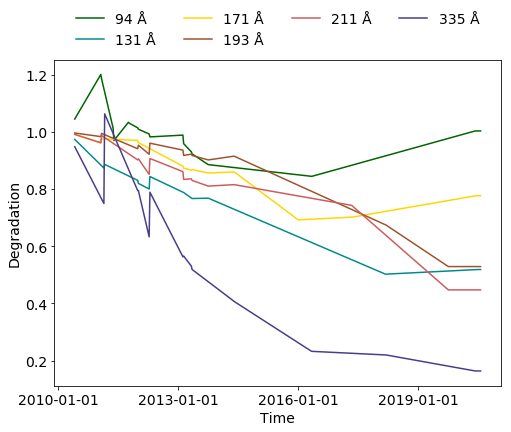

In [5]:
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue','cornflowerblue']
time_support()  # Pass astropy.time.Time directly to matplotlib
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
i=0
for c in channels:
    ax.plot(tims, deg[c], label=f'{c.value:.0f} Å',color=clrs[i])
#     ax.set_xlim(tims[[0, -1]])
#     ax.set_xlim(time.Time([2010,2021],format='decimalyear'))
    ax.set_xticks(time.Time(np.arange(2010,2021,3),format='decimalyear'))
    ax.legend(frameon=False, ncol=4, bbox_to_anchor=(0.5, 1), loc='lower center')
    ax.set_xlabel('Time')
    ax.set_ylabel('Degradation')
    i+=1

In [6]:
tt=time.Time(['2010-01-01T00:00:00.000','2021-01-01T00:00:00.000'],format='isot')
print(tt.decimalyear)

[2010. 2021.]


In [7]:
tt=time.Time(np.arange(2010,2022),format='decimalyear')
tt.isot

array(['2010-01-01T00:00:00.000', '2011-01-01T00:00:00.000',
       '2012-01-01T00:00:00.000', '2013-01-01T00:00:00.000',
       '2014-01-01T00:00:00.000', '2015-01-01T00:00:00.000',
       '2016-01-01T00:00:00.000', '2017-01-01T00:00:00.000',
       '2018-01-01T00:00:00.000', '2019-01-01T00:00:00.000',
       '2020-01-01T00:00:00.000', '2021-01-01T00:00:00.000'], dtype='<U23')

In [8]:
# Load in the sswidl created temperature response file, no time_depend
trin=io.readsav('aia_resp_eve.dat')

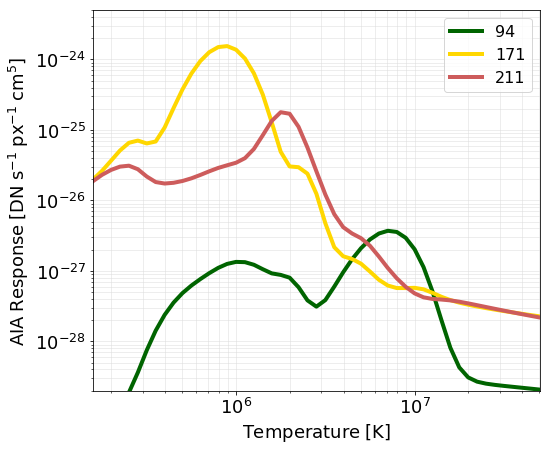

In [9]:
logt=trin['logt']
tr094=trin['tr'][0]
tr171=trin['tr'][2]
tr211=trin['tr'][4]

clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue','cornflowerblue']

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 7))
plt.loglog(10**logt,tr094,label='94',color=clrs[0],lw=4)
plt.loglog(10**logt,tr171,label='171',color=clrs[2],lw=4)
plt.loglog(10**logt,tr211,label='211',color=clrs[4],lw=4)
plt.xlabel('$\mathrm{Temperature\;[K]}$')
plt.ylabel('$\mathrm{AIA\;Response\;[DN\;s^{-1}\;px^{-1}\;cm^5]}$')
plt.ylim([2e-29,5e-24])
plt.xlim([10**5.2,10**7.7])
plt.legend(ncol=1,prop={'size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
# plt.tight_layout(rect = [0, 0, 1, 1])
# plt.savefig('aia_resp_eve.pdf',box_inches='tight')  
plt.show()

In [10]:
#  EM_{data_deg_cor} => correct data for time degradation, temperature response no correction
#  EM_{tr_deg_cor} => data no correction, correct temperature response for time degradation
# 
# EM_{tr_deg_cor} is the approach we currently take -> all correction in temp resp
# 
#  Find for 2014-09-09 (EM_data_deg_cor) / (EM_tr_deg_cor) = 1.225952955743566
#  Find for 2015-09-09 (EM_data_deg_cor) / (EM_tr_deg_cor) = 1.1349092925786517
#  Find for 2016-09-09 (EM_data_deg_cor) / (EM_tr_deg_cor) = 1.0971794786759297
#  Find for 2017-09-09 (EM_data_deg_cor) / (EM_tr_deg_cor) = 1.062230910525875
#  Find for 2018-09-09 (EM_data_deg_cor) / (EM_tr_deg_cor) = 0.9992916156903795
#  Find for 2019-09-09 (EM_data_deg_cor) / (EM_tr_deg_cor) = 1.225952955743566

time_obs = time.Time('2018-09-09T12:00:00', scale='utc')
channels=[94,171,211]*u.angstrom

In [11]:
# degradation function here the same as from sswidl
#  corr_euv = aia_bp_get_corrections(version=8)
#  corr_euv.ea_over_ea0  (for chosen time and channels)
degs=np.empty(3)
for i in np.arange(3):
    degs[i]=degradation(channels[i],time_obs,correction_table=correction_table)
print(degs)    

[0.93611202 0.73458893 0.57702289]


In [12]:
#  Want to make some time degraded data in each of the 3 channels
#  Then work out what the Fe18 degraded data
#  From this work out the EM for some T using the temperature response corrected for the degradation

#  Then compare this to the EM for the same T using none degraded Fe18 
#  and original temperature response

logt1=np.log10(1e6)
logt2=np.log10(7e6)
em=1e28

# Work out the non-degraded data values
g094=em*10**np.interp(logt1,logt,np.log10(tr094)) + em*10**np.interp(logt2,logt,np.log10(tr094))
g171=em*10**np.interp(logt1,logt,np.log10(tr171)) + em*10**np.interp(logt2,logt,np.log10(tr171))
g211=em*10**np.interp(logt1,logt,np.log10(tr211)) + em*10**np.interp(logt2,logt,np.log10(tr211))

# Work out the degraded data values
dg094=g094 * degs[0]
dg171=g171 * degs[1]
dg211=g211 * degs[2]

print(g094,g171,g211)
print(dg094,dg171,dg211)

50.2210231462894 13758.946591952183 354.09753114756217
47.012503563038265 10107.16981605688 204.3223806580015


In [13]:
#  Work out the Fe18 values
gf18=g094 - g171/450. - g211/120.
#  And from the degraded data
dgf18=dg094 - dg171/450. - dg211/120.

print(gf18,dgf18)


16.69477351572153 22.849439688539633


In [14]:
# Work out the temperature response for Fe18
trf18=tr094 - tr171/450. - tr211/120.

#  Work out the temperature response for Fe18 with degredation correction 
#  Version would normally calculate if time_depend used in aia_get_response (sswidl)
dtrf18=(degs[0]*tr094) - (degs[1]*tr171)/450. - (degs[2]*tr211)/120.

trf18[trf18 < 0]=0
dtrf18[dtrf18 < 0]=0

In [15]:
# What isothermal EM will we get from each Fe18?

# Here EM_{data_deg_cor} if em_calc and EM_{tr_deg_cor} is dem_calc
em_calc = gf18 / trf18
dem_calc = dgf18 / dtrf18

print(10**logt[57])
print(em_calc[57],dem_calc[57])
print(100*(em_calc[57]-dem_calc[57])/em_calc[57])

#  In this case only a few % difference
print(np.nanmean(em_calc/dem_calc))

7079456.289251887
4.511816597411051e+27 6.589788695215483e+27
-46.05621822032404
inf


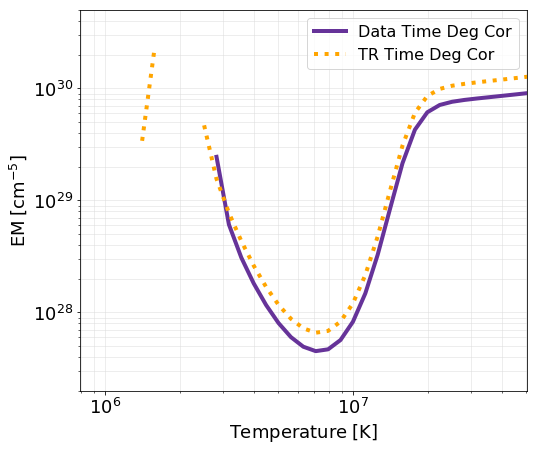

In [16]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 7))
plt.loglog(10**logt,em_calc,label='Data Time Deg Cor',color='rebeccapurple',lw=4)
plt.loglog(10**logt,dem_calc,label='TR Time Deg Cor',color='orange',lw=4,ls='dotted')
plt.xlabel('$\mathrm{Temperature\;[K]}$')
plt.ylabel('$\mathrm{EM\;[cm^{-5}]}$')
plt.ylim([2e27,5e30])
plt.xlim([10**5.9,10**7.7])
plt.legend(ncol=1,prop={'size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
# plt.tight_layout(rect = [0, 0, 1, 1])
# plt.savefig('aia_resp_eve.pdf',box_inches='tight')  
plt.show()

In [17]:
# print(10**np.interp(logt2,logt,np.log10(em_calc)))

In [18]:
# dt=TimeDelta(24.*60.*60.,format='sec')
# tims=t0+dt* np.arange(0, 280,14)
# print(tims)